# Import Data
The data includes 3D world coordinates, 2D image coordinates, and images of a chessboard box captured from two perspectives.

In [43]:
import cv2
import numpy as np
import scipy.io
from scipy import signal
import scipy
import matplotlib.pyplot as plt

In [44]:
point3D = np.loadtxt('../data/Point3D.txt', delimiter=' ')
point2D1 = np.load('../data/2D_coordinate/image1.npy')
point2D2 = np.load('../data/2D_coordinate/image2.npy')
img1 = cv2.imread('../data/image1.jpeg')
img2 = cv2.imread('../data/image2.jpeg')

(A) Compute the projection matrix $ {P} $ from a set of 2D-3D point correspondences by using the leastsquares (eigenvector) method for each image.

A pair of corresponding point in homogenous coordinate satisfies:

$$
\newcommand{\norm}[1]{\lVert #1 \rVert}
\newcommand{\bb}[1]{\mathbf{ #1 }}
\begin{align}
\begin{pmatrix}
u \\ v \\ 1
\end{pmatrix}
&\sim
\bb{P}
\begin{pmatrix}
X \\ Y \\ Z \\ 1
\end{pmatrix}
\end{align}
$$

Where $\sim$ means equality up to scale. We can derive two equations:

$$
\begin{align}
x = \frac
{p_{11} X + p_{12} Y + p_{13} Z + P_{14}}
{p_{31} X + p_{32} Y + p_{33} Z + P_{34}}
,
y = \frac
{p_{21} X + p_{22} Y + p_{23} Z + P_{24}}
{p_{31} X + p_{32} Y + p_{33} Z + P_{34}}
\end{align}
$$

Rearrange it in matrix form:

$$
\begin{pmatrix}
X & Y & Z  & 1 & 0 & 0 & 0 & 0 & -uX & -uY & -uZ & -u \\
0 & 0 & 0 & 0 & X & Y & Z & 1 & -vX & -vY & -vZ & -v \\
&&&&&&\vdots\\
&&&&&&\vdots\\
&&&&&&\vdots\\
\end{pmatrix}
\begin{pmatrix}
p_{11} \\ p_{12} \\ p_{13} \\ \vdots \\ p_{34}
\end{pmatrix}
= \bb{0}
$$

It is a homogenious system $\bb{A}\bb{p} = \bb{0}$. Since there are 12 unknows, but the actual degree of freedom of $\bb{p}$ is 11 (5 in $\bb{K}$, 3 in $\bb{R}$, 3 in $\bb{T}$), we add one constraint to the system: $\norm{\bb{p}} = 1$.

Usually more than 6 correspondences are given, the system doesn't have an unique solution. Instead, we try to find the $\bb{p}$ that minimize $\norm{\bb{Ap } - \bb{0}}$. The solution is the eigenvector of $\bb{A^T A}$ which has minimum eigenvalue. The proof is given in Appendix.

Another way to solve this system is to use least square method. However the unit norm constraint cannot be expressed in our system, we use another constraint instead,

$$
p_{11} + p_{12} + \ldots + p_{34} = 1
$$

After adding constraint, the system becomes:

$$
\begin{pmatrix}
X & Y & Z  & 1 & 0 & 0 & 0 & 0 & -xX & -xY & -xZ & -x \\
0 & 0 & 0 & 0 & X & Y & Z & 1 & -yX & -yY & -yZ & -y \\
 & & & & & &\vdots\\
 & & & & & &\vdots\\
1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
\end{pmatrix}
\begin{pmatrix}
p_{11} \\ p_{12} \\ p_{13} \\ \vdots \\ p_{34}
\end{pmatrix} = 
\begin{pmatrix}
0 \\ 0 \\ 0 \\ \vdots \\ 1
\end{pmatrix}
$$

In [45]:
def Projection_Matrix(point2D, point3D):
    ########################################################################
    # TODO:                                                                #
    #   Using 2D coordinator and 3D coordinator,                           #
    #   , calculate the 3D to 2D projection matrix P                       #
    ########################################################################

    lenPoints = len(point3D)
    A = []
    B = []
    M = np.zeros((11, 1))

    for n in range(lenPoints):
        # X, Y, Z = point3D[n]
        # u, v = point2D[n]

        X = (point3D[n, 0]).astype(float)  # Get the X component of the 3D coordinates
        Y = (point3D[n, 1]).astype(float)  # Get the Y component of the 3D coordinates
        Z = (point3D[n, 2]).astype(float)  # Get the Z component of the 3D coordinates
        u = (point2D[n, 0]).astype(float)  # Get the u component of the 2D coordinates
        v = (point2D[n, 1]).astype(float)  # Get the v component of the 2D coordinates

        A.append([X, Y, Z, 1, 0, 0, 0, 0, -u*X, -u*Y, -u*Z])
        A.append([0, 0, 0, 0, X, Y, Z, 1, -v*X, -v*Y, -v*Z])
        B.append(u)
        B.append(v)

    A = np.array(A)
    B = np.array(B)

    # 使用最小平方法解 Ax = B
    m, _, _, _ = np.linalg.lstsq(A, B, rcond=None)

    # 補上常數項 1 並 reshape 成 3x4 矩陣
    M = np.append(m, 1)
    M = np.resize(M,(3, 4))
    
    # # 正規化
    # M = M / M[-1, -1] 
    
    ########################################################################
    #                                                                      #
    #                           End of your code                           #
    #                                                                      # 
    ########################################################################
    return M

In [46]:
P1 = Projection_Matrix(point2D1, point3D)
P2 = Projection_Matrix(point2D2, point3D)

In [47]:
P1

array([[ 3.69740581e+01, -1.90846173e+01, -1.16387874e+01,
         1.80441840e+02],
       [ 9.48201494e-01,  8.04695185e+00, -4.24853737e+01,
         2.97421016e+02],
       [-8.07322748e-03, -4.42700286e-02, -3.81588137e-02,
         1.00000000e+00]])

In [48]:
P2

array([[ 3.31131840e+01,  3.89075129e+00, -1.11825662e+01,
         2.41258799e+02],
       [-3.05543797e+00,  2.97120693e+00, -3.53360055e+01,
         2.83144884e+02],
       [ 2.31183611e-02, -3.97563075e-02, -3.71148667e-02,
         1.00000000e+00]])

In [49]:
# Verify the projection matrix (P), use P to project the 3D coordinator to 2D coordinates
# input: P, 3D world coordinator, output: 2D image coordinator
def Verify(P,point3D):
    lenPoints = len(point3D) # 取得 3D 點的數量 -> 36
    ThreeD = np.zeros((lenPoints,4),dtype=np.float32) # 齊次座標[X,Y,Z,1]
    for i in range(lenPoints):
        for j in range(3):
            ThreeD[i,j]=point3D[i,j]
    
    for i in range(lenPoints):
        ThreeD[i,3]=1 
    # print(f"ThreeD: {ThreeD.shape}") # (36, 4)
    
    TwoDD = np.zeros((lenPoints,3),dtype=np.float32) # 儲存投影後 2D 點的陣列
    for i in range(lenPoints):
        TwoDD[i] = P.dot(ThreeD[i])
        TwoDD[i] = TwoDD[i]/TwoDD[i,-1]
    
    # print(f"TwoDD: {TwoDD.shape}") # (36, 3)
    
    
    SE = 0.000 # 計算均方根誤差
    for i in range(lenPoints):
        SE = SE + np.square(TwoDD[i,0]-point2D1[i,0])+np.square(TwoDD[i,1]-point2D1[i,1])
    RMSE = np.sqrt(SE/lenPoints)
    
    return RMSE, TwoDD

In [50]:
def Project(img, point2D, TwoD, save_name):
    x = point2D[:,0]
    y = point2D[:,1]
    x1 = TwoD[:,0]
    y1 = TwoD[:,1]
    fig = plt.figure()
    img12 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(20,10))
    plt.plot(x,y,"o", label="original point")
    plt.plot(x1,y1,"x", label="projected point")
    plt.legend(loc='upper right')
    plt.imshow(img12)
    plt.savefig('../output/' + save_name + '.png')

In [51]:
RMSE1, TwoDD1 = Verify(P1,point3D)
RMSE2, TwoDD2 = Verify(P2,point3D)
print(RMSE1, RMSE2)

1.215362935781567 52.01368724958299


<Figure size 640x480 with 0 Axes>

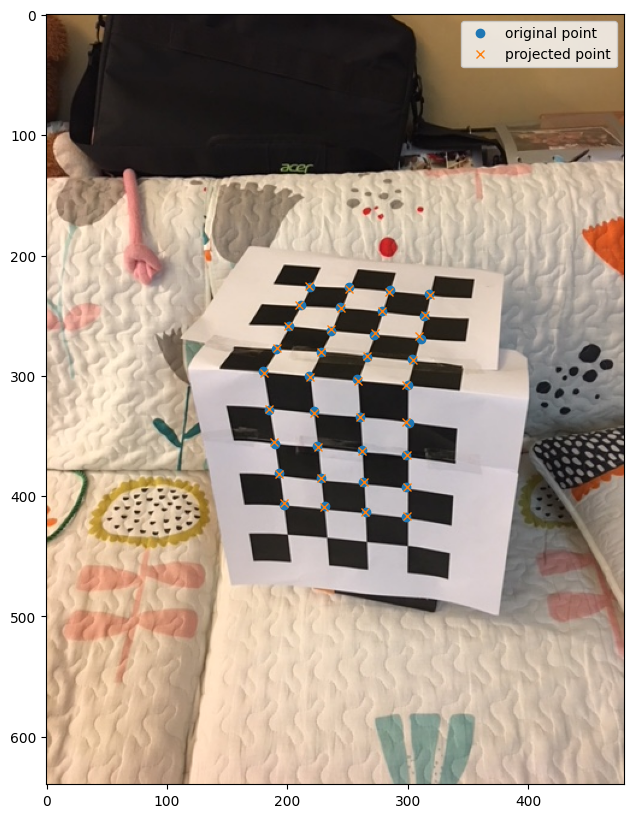

In [52]:
Project(img1, point2D1, TwoDD1,save_name="verify_of_chessboard_1")

<Figure size 640x480 with 0 Axes>

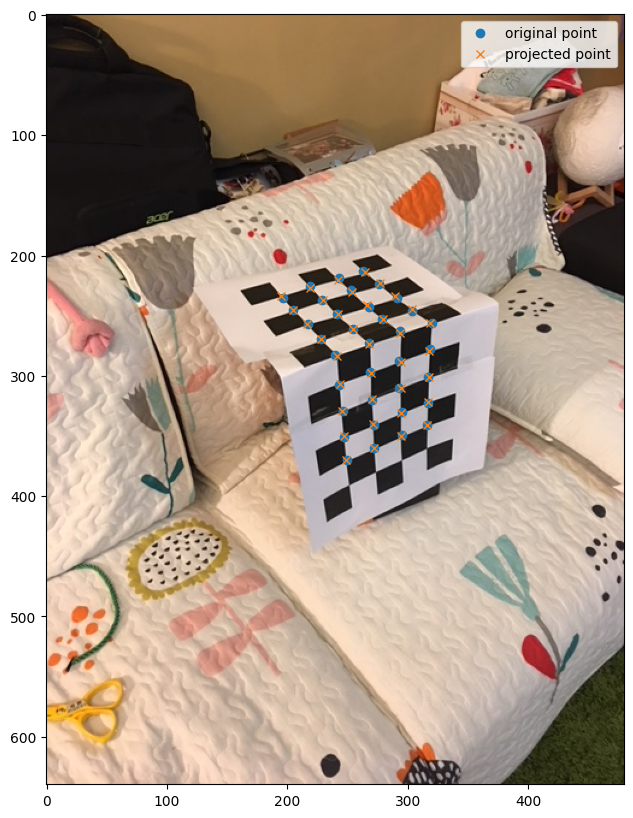

In [53]:
Project(img2, point2D2, TwoDD2,save_name="verify of chessboard_2")

(B) Decompose the two computed projection matrices from (A) into the camera intrinsic matrices K, rotation matrices R and translation vectors t by using the Gram-Schmidt process.

### K, R, T

$$
\begin{align}
\bb{P} 
&= \bb{K} [\bb{R} \mid \bb{T}] = [\bb{KR} \mid \bb{KT}] \\ 
&= [\bb{P_{3\times3}} \mid \bb{P_4}] = [\bb{M} \mid \bb{P_4}]
\end{align}
$$

That is,

$$
\begin{align}
\bb{M} &= \bb{KR} \\
\bb{P_4} &= \bb{KT}
\end{align}
$$
We know $\bb{K}$ is upper triangular, $\bb{R}$ is orthogonal, we can utilize **RQ-decomposition** to find $\bb{K}, \bb{R}$:

$$
\begin{align}
\bb{M} &= \bb{\hat R} \bb{\hat Q} = \bb{KR} \\
\therefore 
\bb{K} &= \bb{\hat R}\\
\bb{R} &= \bb{\hat Q}
\end{align}
$$

We can use **QR-decomposition** in case you are not able to access RQ-decomposition function (like in matlab). Decomposite $\bb{M^{-1}}$ instead, since the inverse of an upper trigular matrix is upper triangular and the inverse of orthogonal maxtrix is also orthogonal:

$$
\begin{align}
\bb{M^{-1}} &= \bb{\dot Q \dot R} \\
\bb{M} &= \bb{(\dot Q \dot R)^{-1}} = \bb{\dot{R}^{-1}\dot{Q}^{-1}} = \bb{KR} \\
\therefore 
\bb{K} &= \bb{\dot{R}^{-1}}\\
\bb{R} &= \bb{\dot{Q}^{-1}}
\end{align}
$$

And $\bb{T}$ is simply:

$$
\bb{T} = \bb{K^{-1} P_4}
$$

In [54]:
def KRt(P):
    ########################################################################
    # TODO:                                                                #
    #   Extract the intrinsic matrix (K), rotation matrix (R)              #
    #   , and translation vector(T) from the projection matrix.            #
    ########################################################################

    # 取出投影矩陣的前3列
    MP = np.array(P[:, :3])

    # 使用 scipy 的 RQ 分解
    r, q = scipy.linalg.rq(MP)

 
    # 建立對角線矩陣 D，確保 r 的對角線元素為正
    D = np.diag(np.sign(np.diag(r)))
    D_inv = np.linalg.inv(D)

    # 調整 r 和 q
    K1 = r.dot(D)
    R1 = D_inv.dot(q)
        
    # 計算平移向量 T
    T = np.linalg.inv(K1).dot(np.array(P[:, 3]))
    
    # 正規化
    K2 = K1 / K1[-1, -1]    

    ########################################################################
    #                                                                      #
    #                           End of your code                           #
    #                                                                      # 
    ########################################################################
    return K2, R1, T

In [55]:
K1, R1, T1 = KRt(P1)
K2, R2, T2 = KRt(P2)

In [56]:
K1, R1, T1

(array([[674.7060519 ,   8.20409212, 284.53556578],
        [  0.        , 637.90723826, 361.17747713],
        [  0.        ,   0.        ,   1.        ]]),
 array([[ 0.98525963, -0.17075218, -0.01035203],
        [ 0.10266648,  0.63863273, -0.76263217],
        [-0.13683225, -0.75032788, -0.64674957]]),
 array([-2.59427884, -1.69397874, 16.94889085]))

In [57]:
K2, R2, T2

(array([[517.32333531, -13.63516056, 293.73501436],
        [  0.        , 509.28911272, 321.46561071],
        [  0.        ,   0.        ,   1.        ]]),
 array([[ 0.85179967,  0.52302648, -0.02967515],
        [-0.34843723,  0.52334355, -0.77762653],
        [ 0.39118897, -0.67272195, -0.62802577]]),
 array([-1.7500035 , -1.27320666, 16.92113764]))

In [58]:
np.savetxt("../output/intrinsic matrices of chessboard_1.txt",K1)
np.savetxt("../output/rotation matrices of chessboard_1.txt",R1)
np.savetxt("../output/translation vectors of chessboard_1.txt",T1)
np.savetxt("../output/intrinsic matrices of chessboard_2.txt",K2)
np.savetxt("../output/rotation matrices of chessboard_2.txt",R2)
np.savetxt("../output/translation vectors of chessboard_2.txt",T2)



(C) Re-project 2D points on each of the chessboard images by using the computed intrinsic matrix, rotation matrix and translation vector. Show the results (2 images) and compute the point reprojection root-mean-squared errors. 

In [59]:
def ReProject2D(K, R, T, point2D, point3D):
    lenPoints = len(point3D)
    Pro = np.zeros((3,4),dtype=np.float32)
    Pro[0,0] = 1
    Pro[1,1] = 1
    Pro[2,2] = 1
    
    Rt = np.zeros((4,4),dtype=np.float32)
    for i in range(3):
        for j in range(3):
            Rt[i,j]=R[i,j]
    Rt[0,3]=T[0]
    Rt[1,3]=T[1]
    Rt[2,3]=T[2]
    Rt[3,3] = 1
    
    KPRt = K.dot(Pro).dot(Rt)
    
    
    ThreeD = np.zeros((lenPoints,4),dtype=np.float32)
    for i in range(lenPoints):
        for j in range(3):
            ThreeD[i,j]=point3D[i,j]
    
    for i in range(lenPoints):
        ThreeD[i,3]=1
    
    TwoD = np.zeros((lenPoints,3),dtype=np.float32)
    for i in range(lenPoints):
        TwoD[i] = KPRt.dot(ThreeD[i])
        TwoD[i] = TwoD[i]/TwoD[i,-1]
    
    SE = 0.000
    for i in range(lenPoints):
        SE = SE + np.square(TwoD[i,0]-point2D[i,0])+np.square(TwoD[i,1]-point2D[i,1])
    
    RMSE = np.sqrt(SE/lenPoints)
    
    SEX = 0.000
    for i in range(lenPoints):
        SEX = SEX + np.square(TwoD[i,0]-point2D[i,0])
    
    SEY = 0.000
    for i in range(lenPoints):
        SEY = SEY + np.square(TwoD[i,1]-point2D[i,1])    
        
    return RMSE, TwoD, SEX, SEY



In [60]:
RMSE1, TwoD1, SE_X1, SE_Y1 = ReProject2D(K1, R1, T1, point2D1, point3D)
RMSE2, TwoD2, SE_X2, SE_Y2 = ReProject2D(K2, R2, T2, point2D2, point3D)

In [61]:
print("RMSE of 1st image: ",RMSE1)
print("RMSE of 2nd image: ",RMSE2)

RMSE of 1st image:  1.215364492113766
RMSE of 2nd image:  1.2567044089192316


<Figure size 640x480 with 0 Axes>

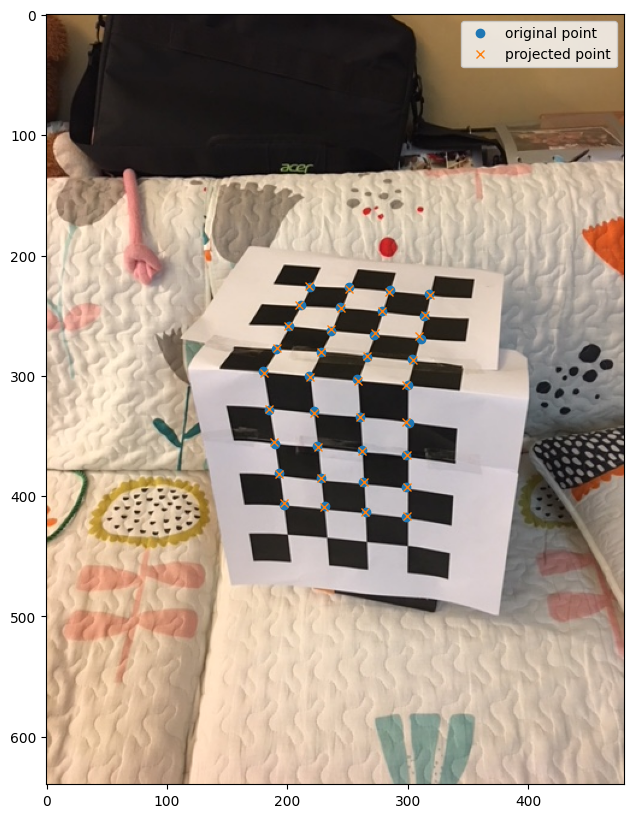

In [62]:
Project(img1, point2D1, TwoD1,save_name='ReProject2D of chessboard_1')

<Figure size 640x480 with 0 Axes>

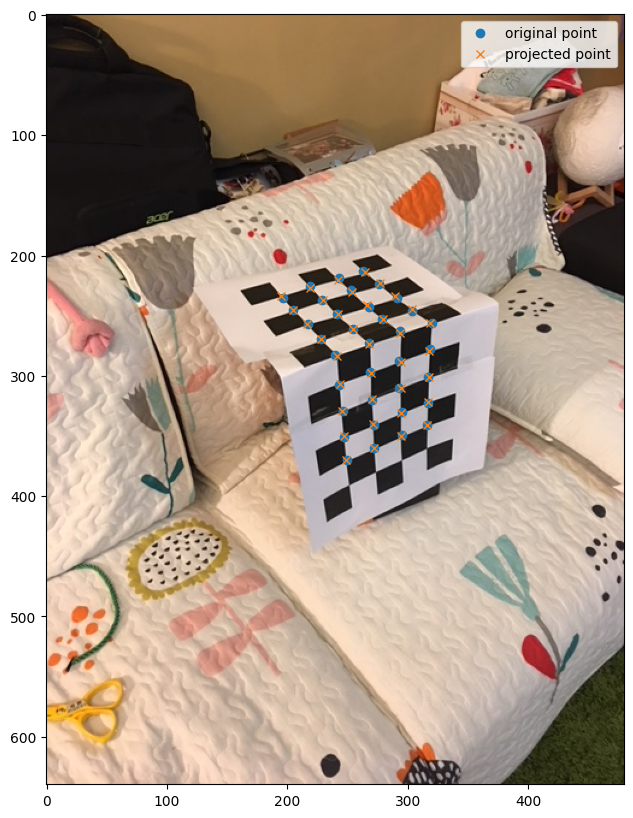

In [63]:
Project(img2, point2D2, TwoD2,save_name='ReProject2D of chessboard_2')

(D) Plot camera poses for the computed extrinsic parameters (R, t) and then compute the angle between the two camera pose vectors.

In [64]:
from visualize import visualize
# Input:
# pts: 36x3 3D points
# R1: 3x3 rotation matrix of image 1
# T1: 3x1 translation vector of image 1
# R2: 3x3 roatation matrix of image 2
# T2: 3x1 translation vector of image 2

In [65]:
T11 = T1.reshape(3,1)
T22 = T2.reshape(3,1)

Angle between two cameras:  30.97297189059777


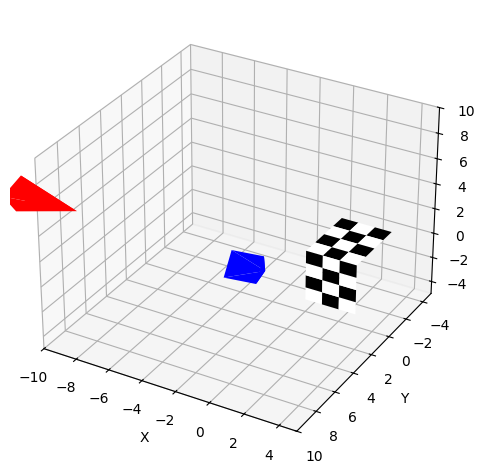

In [66]:
save_name='3D_12'
visualize(point3D, R1, T1.reshape(3,1), R2, T2.reshape(3,1),save_name)

(E) Print out two “chessboard.png” in the attached file and paste them on a box. Take two pictures from different angles. For each image, perform the steps above (A ~ D).

43.5129892209441 43.02140138146952
RMSE of 3thre image:  1.5397182264481037
RMSE of 4four image:  2.154857639686079
Angle between two cameras:  29.471299691730543


<Figure size 640x480 with 0 Axes>

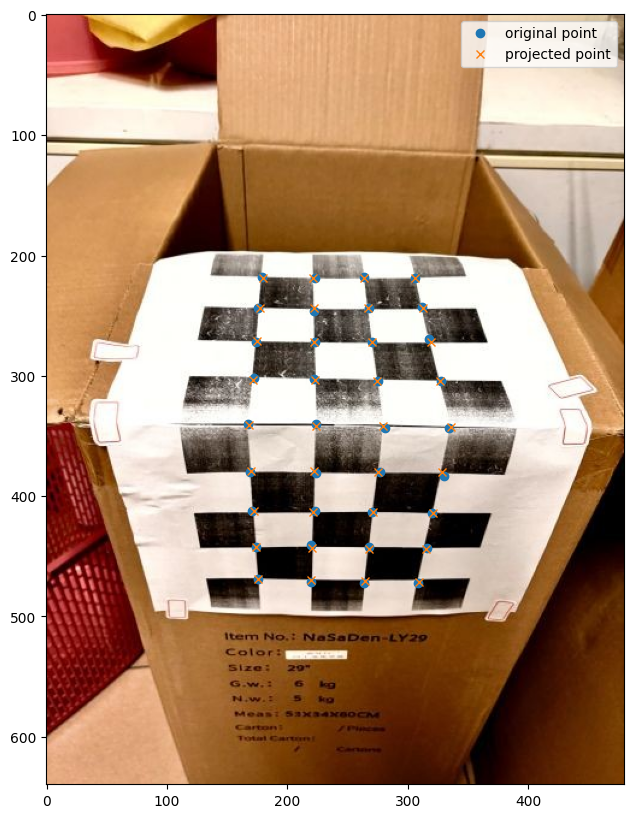

<Figure size 640x480 with 0 Axes>

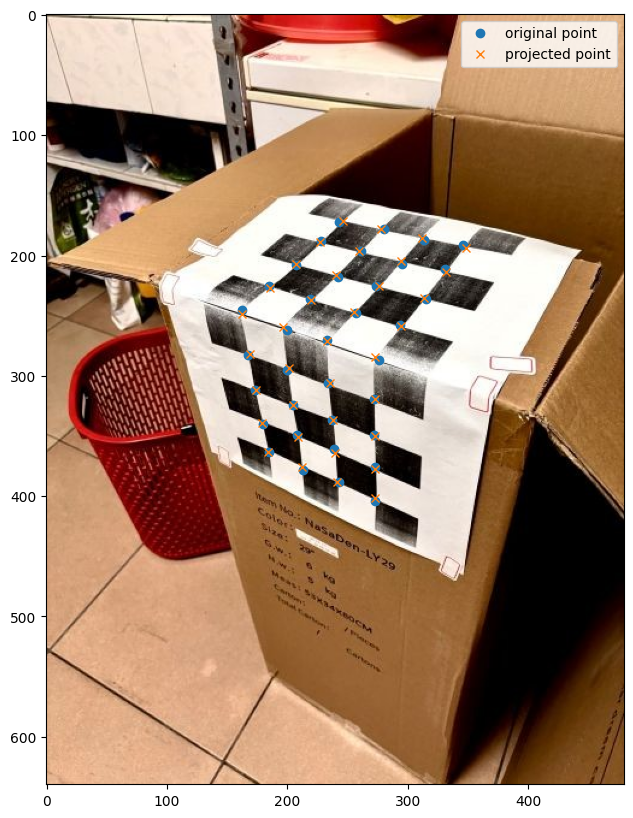

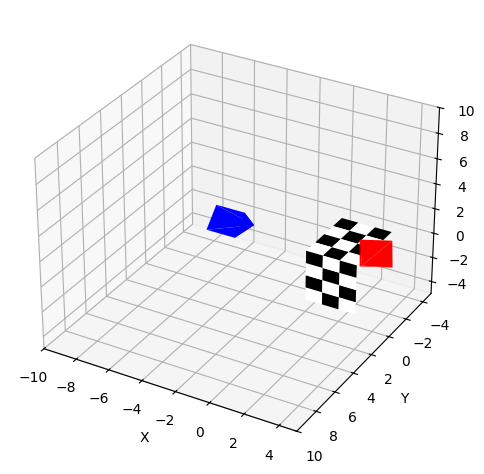

In [67]:
point3D = np.loadtxt('../data/Point3D.txt', delimiter=' ')
point2D3 = np.load('../data/2D_coordinate/Point2D_3.npy')
point2D4 = np.load('../data/2D_coordinate/Point2D_6.npy')
img3 = cv2.imread('../data/image3.jpeg')
img4 = cv2.imread('../data/image6.jpeg')

P3 = Projection_Matrix(point2D3, point3D)
P4 = Projection_Matrix(point2D4, point3D)
RMSE3_i, TwoDD3 = Verify(P3,point3D)
RMSE4_i, TwoDD4 = Verify(P4,point3D)
print(RMSE3_i, RMSE4_i)

K3, R3, T3 = KRt(P3)
K4, R4, T4 = KRt(P4)
RMSE3, TwoD3, SE_X3, SE_Y3 = ReProject2D(K3, R3, T3, point2D3, point3D)
RMSE4, TwoD4, SE_X4, SE_Y4 = ReProject2D(K4, R4, T4, point2D4, point3D)
print("RMSE of 3thre image: ",RMSE3)
print("RMSE of 4four image: ",RMSE4)

Project(img3, point2D3, TwoD3,save_name='ReProject2D of chessboard_3')
Project(img4, point2D4, TwoD4,save_name='ReProject2D of chessboard_4')

save_name='3D_34'
visualize(point3D, R3, T3.reshape(3,1), R4, T4.reshape(3,1),save_name)

In [69]:
P3

array([[ 5.48033707e+01, -1.74674919e+01, -1.29677366e+01,
         1.67868697e+02],
       [-9.34589765e-01,  1.27539278e+01, -6.17066424e+01,
         3.40938377e+02],
       [-3.99116874e-03, -8.11748148e-02, -6.32320695e-02,
         1.00000000e+00]])

In [70]:
P4

array([[ 2.74144742e+01, -3.07294569e+01, -1.62761308e+01,
         1.62324852e+02],
       [ 1.90192110e+00,  1.25390149e+01, -5.02849917e+01,
         2.48669601e+02],
       [-3.47239343e-02, -3.98107561e-02, -5.93470395e-02,
         1.00000000e+00]])

In [71]:
print(RMSE3_i, RMSE4_i)

43.5129892209441 43.02140138146952


In [72]:
K3, R3, T3

(array([[540.00489625,  -3.49987328, 190.42330763],
        [  0.        , 548.85972584, 270.68900689],
        [  0.        ,   0.        ,   1.        ]]),
 array([[ 0.99924525, -0.03216316, -0.02178195],
        [ 0.00257928,  0.61444141, -0.78895824],
        [-0.03875912, -0.78830659, -0.61406062]]),
 array([-0.39755682,  1.24295362,  9.71122133]))

In [73]:
K4, R4, T4

(array([[521.70294868,   3.3306973 , 196.01136849],
        [  0.        , 528.38455883, 383.20025579],
        [  0.        ,   0.        ,   1.        ]]),
 array([[ 0.82326528, -0.55732035, -0.10783461],
        [ 0.36225785,  0.66206499, -0.65607865],
        [-0.43703951, -0.50106284, -0.74694879]]),
 array([-0.79223084, -3.20451943, 12.58611717]))

(F) Instead of mark the 2D points by hand, you can find the 2D points in your images automatically by using corner detection, hough transform, etc.

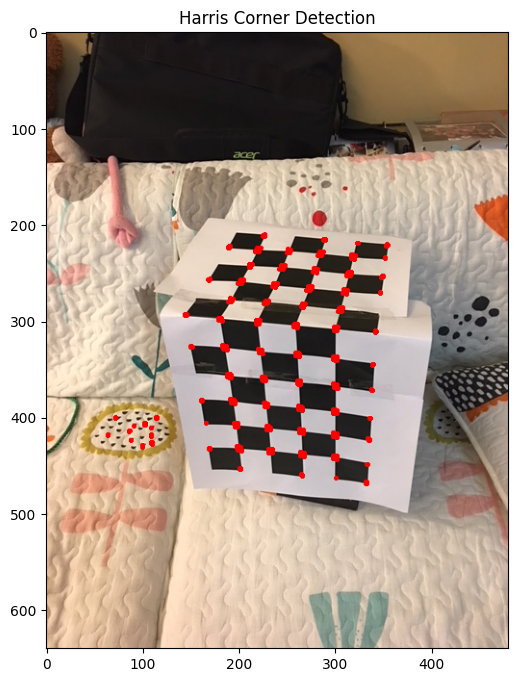

2404
[[226 209]
 [227 209]
 [228 209]
 ...
 [332 470]
 [333 470]
 [334 470]]


In [75]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def automatic_2d_points(image_path, grid_shape=(9, 6), visualize=True):
    """
    自動標註2D角點
    使用 Harris 角點檢測來自動標註棋盤格角點

    :param image_path: 影像路徑
    :param grid_shape: 標準棋盤格的行列數目 (cols, rows)，記得它是內部角點數量
    :param visualize: 是否可視化顯示
    :return: 標註的2D點
    """
    # 讀取影像
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Harris 角點檢測
    gray_float = np.float32(gray)
    dst = cv2.cornerHarris(gray_float, blockSize=5, ksize=3, k=0.2)
    dst = cv2.dilate(dst, None)

    # 設定角點的閾值
    threshold = 0.3 * dst.max()
    corners = np.argwhere(dst > threshold)
    corners = np.flip(corners, axis=1)  # 換成 (x, y) 格式

    # 可視化結果
    if visualize:
        img_copy = img_rgb.copy()
        for corner in corners:
            cv2.circle(img_copy, tuple(corner), 1, (255, 0, 0), -1)  # 標註角點

            
        plt.figure(figsize=(8, 8))
        plt.imshow(img_copy)
        plt.title("Harris Corner Detection")
        plt.show()

    return corners

# 使用範例
image_path = '../data/image1.jpeg'  # 影像路徑
detected_points = automatic_2d_points(image_path, grid_shape=(9, 6), visualize=True)

print(len(detected_points))
print(detected_points)
